# Aim

The aim of the anaylsis is to get basic cNE properties and compare properties of cNEs in A1 and MGB

In [64]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, stats
from scipy.stats import zscore
from plot_box import plot_significance_star
from ne_toolbox import moran_i, calc_strf_ptd



# get colors for box plots
colors = sns.color_palette("Paired")
A1_color = (colors[1], colors[0], colors[3], colors[2])
MGB_color = (colors[5], colors[4], colors[7], colors[6])
colors = list(MGB_color) + list(A1_color)

In [65]:
datafolder = 'E:\Congcong\Documents\data\comparison\data-summary'
ne_file = os.path.join(datafolder, 'cNE.json')
ne = pd.read_json(ne_file)
su = pd.read_json(os.path.join(datafolder, 'single_units.json'))

In [21]:
ne.head()

,exp,probe,depth,cNE,members,pattern,strf_sig,crh_sig,freq_span_oct,region
0,191126211411,H31x64,5214,0,"[3, 4, 9]","[-0.0756121417, 0.0515729986, 0.0342513859, 0....",True,False,3.211138,MGB
1,191126211411,H31x64,5214,1,"[1, 8, 10]","[0.2273610862, 0.2949384624, 0.240309528300000...",False,True,3.010442,MGB
2,191126211411,H31x64,5214,2,"[1, 5, 7]","[0.0742804231, 0.45692949320000004, -0.4728641...",True,True,2.107309,MGB
3,200127153707,H31x64,5004,0,"[0, 3, 6]","[0.4240616038, 0.09859236900000001, 0.26063851...",False,False,2.207657,MGB
4,200709232021,H22x32,1300,0,"[7, 13, 16, 20]","[0.047847763700000004, 0.08136203630000001, 0....",True,True,0.401392,A1


### Add Features (Run Once)

In [23]:
# add frequency span of all members
freq_span = []
su_sig = su[su.strf_sig]
for i in range(len(ne)):
    cNE = ne.iloc[i]
    exp = cNE.exp
    probe = cNE.probe
    members = su_sig[(su_sig.exp == exp) & (su_sig.probe == probe)]
    members = members[members['index'].apply(lambda x: x in cNE.members)]
    # get frequency span of members
    if len(members) > 1:
        freq_span.append(np.log2(members.bf.max() / members.bf.min()))
    else:
        freq_span.append(np.nan)

ne['freq_span_oct'] = freq_span

# add region of the recording
region = ['MGB' if x == 'H31x64' else 'A1' for x in ne['probe']]
ne['region'] = region
ne.to_json(ne_file)

#### reliability index PTD, Moran's I, ASI, MI from subsampled units

In [66]:
datafolder = 'E:\Congcong\Documents\data\comparison\data-summary'
subsample_file = os.path.join(datafolder, 'subsample_ne_neuron.json')
subsample = pd.read_json(subsample_file)

region = ['MGB' if x == 'H31x64' else 'A1' for x in subsample.probe]
subsample['region'] = region

for rf in ('strf', 'crh'):
    for ri in ('_ri_neuron', '_ri_cNE', '_ri_ne_spike'):
        # flatten the columns contaning ri
        subsample[rf+ri] = subsample[rf+ri].apply(lambda x:np.array(x, dtype=np.float64)).apply(lambda x: x.flatten())
        # get ri std
        subsample[rf+ri+'_std'] =  subsample[rf+ri].apply(np.nanstd)
        # get ri mean
        subsample[rf+ri+'_mean'] =  subsample[rf+ri].apply(np.nanmean)
        
subsample = pd.merge(subsample,ne[['exp', 'depth', 'cNE', 'strf_sig', 'crh_sig']], on=['exp', 'depth', 'cNE'])
subsample.to_json('E:\Congcong\Documents\data\comparison\data-summary\subsample_ne_neuron.json')
print(len(subsample))

773


In [67]:
subsample.columns

Index(['exp', 'depth', 'probe', 'cNE', 'member', 'n_events', 'strf_neuron',
       'strf_cNE', 'strf_ne_spike', 'strf_ri_neuron', 'strf_ri_cNE',
       'strf_ri_ne_spike', 'crh_neuron', 'crh_cNE', 'crh_ne_spike',
       'crh_ri_neuron', 'crh_ri_cNE', 'crh_ri_ne_spike', 'ptd_neuron',
       'ptd_cNE', 'ptd_ne_spike', 'morani_neuron', 'morani_cNE',
       'morani_ne_spike', 'asi_neuron', 'asi_cNE', 'asi_ne_spike', 'mi_neuron',
       'mi_cNE', 'mi_ne_spike', 'mi_raw_neuron', 'mi_raw_cNE',
       'mi_raw_ne_spike', 'nonlin_centers_neuron', 'nonlin_centers_cNE',
       'nonlin_centers_ne_spike', 'nonlin_fr_neuron', 'nonlin_fr_cNE',
       'nonlin_fr_ne_spike', 'region', 'strf_ri_neuron_std',
       'strf_ri_neuron_mean', 'strf_ri_cNE_std', 'strf_ri_cNE_mean',
       'strf_ri_ne_spike_std', 'strf_ri_ne_spike_mean', 'crh_ri_neuron_std',
       'crh_ri_neuron_mean', 'crh_ri_cNE_std', 'crh_ri_cNE_mean',
       'crh_ri_ne_spike_std', 'crh_ri_ne_spike_mean', 'strf_sig', 'crh_sig'],
      dtype='

In [80]:
for unit_type in ('_neuron', '_cNE', '_ne_spike'):
    subsample['ptd' + unit_type] = subsample['ptd' + unit_type].apply(np.nanmean)
    subsample['morani' + unit_type] = subsample['morani' + unit_type].apply(np.nanmean)
    #subsample['asi' + unit_type] = subsample['asi' + unit_type].apply(np.nanmean)
    subsample['mi' + unit_type] = subsample['mi' + unit_type].apply(np.nanmean)
subsample_summary = subsample[['exp', 'depth', 'probe', 'cNE', 'member', 'n_events', 'region', 
                               'strf_ri_neuron_std', 'strf_ri_neuron_mean', 
                               'strf_ri_cNE_std', 'strf_ri_cNE_mean',
                               'strf_ri_ne_spike_std', 'strf_ri_ne_spike_mean', 
                               'crh_ri_neuron_std', 'crh_ri_neuron_mean', 
                               'crh_ri_cNE_std', 'crh_ri_cNE_mean',
                               'crh_ri_ne_spike_std', 'crh_ri_ne_spike_mean',
                               'ptd_neuron', 'ptd_cNE', 'ptd_ne_spike', 
                               'morani_neuron', 'morani_cNE', 'morani_ne_spike', 
                               'asi_neuron', 'asi_cNE', 'asi_ne_spike', 
                               'mi_neuron', 'mi_cNE', 'mi_ne_spike','strf_sig', 'crh_sig']]
subsample_summary.to_json('E:\Congcong\Documents\data\comparison\data-summary\subsample_ne_neuron_summary.json')

### Stimulus Encoding Properties of cNEs

#### frequency span: strf+ vs strf- cNEs

significance test: sig vs nonsig
MannwhitneyuResult(statistic=1405.0, pvalue=0.5179266846707165)
MannwhitneyuResult(statistic=610.5, pvalue=0.17778718553002126)


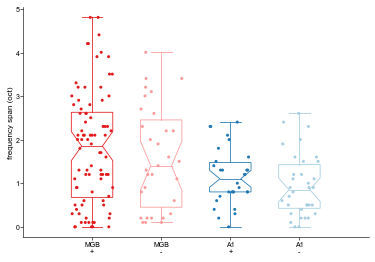

In [69]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
my_order = ['MGB_True', 'MGB_False', 'A1_True', 'A1_False']
palette = MGB_color[:2] + A1_color[:2]
ne['region_sig'] = ne[['region', 'strf_sig']].apply(tuple, axis=1)
ne['region_sig'] = ne['region_sig'].apply(lambda x: '_'.join([str(y) for y in x]))
sns.stripplot(x='region_sig', y='freq_span_oct', data=ne, order=my_order,
              hue='region_sig', hue_order=my_order, palette=palette,
              jitter=0.3, s=3, legend=False)
bplot = sns.boxplot(x='region_sig', y='freq_span_oct', data=ne, order=my_order, 
                    width=0.6, notch=True, flierprops={'marker': ''})
for i,box_col in enumerate(palette):
    
        mybox = bplot.patches[i]
    
        mybox.set_edgecolor(box_col)
        mybox.set_facecolor('w')

        for j in range(i*6,i*6+6):
            line = bplot.lines[j]
            line.set_color(box_col)
            line.set_mfc(box_col)
            line.set_mec(box_col)
xlabels = ['\n'.join(x.split('_')) for x in my_order]
xlabels = [x.replace('True', '+') for x in xlabels]
xlabels = [x.replace('False', '-') for x in xlabels]

ax.set_xticklabels(xlabels)
ax.set_xlim([-1, 4])
ax.set_ylabel('frequency span (oct)')
ax.set_xlabel('')

# significance test between 2 regions
print('significance test: sig vs nonsig')
for i in range(2):
    x=ne[ne['region_sig'] == my_order[i*2]]['freq_span_oct']
    y=ne[ne['region_sig'] == my_order[i*2+1]]['freq_span_oct']
    res = stats.mannwhitneyu(x=x[~np.isnan(x)], 
                            y=y[~np.isnan(y)])
    print(res)
    p = res.pvalue

    plot_significance_star(ax, p, [i*2, i*2+1], 5, 5)
plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\frequency_span_strf_sig.png', bbox_inches='tight', dpi=300)

#### cNE RI vs neuron RI (strf/crh)

In [78]:
subsample_summary.columns

Index(['exp', 'depth', 'probe', 'cNE', 'member', 'n_events', 'region',
       'strf_ri_neuron_std', 'strf_ri_neuron_mean', 'strf_ri_cNE_std',
       'strf_ri_cNE_mean', 'strf_ri_ne_spike_std', 'strf_ri_ne_spike_mean',
       'crh_ri_neuron_std', 'crh_ri_neuron_mean', 'crh_ri_cNE_std',
       'crh_ri_cNE_mean', 'crh_ri_ne_spike_std', 'crh_ri_ne_spike_mean',
       'ptd_neuron', 'ptd_cNE', 'ptd_ne_spike', 'morani_neuron', 'morani_cNE',
       'morani_ne_spike', 'asi_neuron', 'asi_cNE', 'asi_ne_spike', 'mi_neuron',
       'mi_cNE', 'mi_ne_spike'],
      dtype='object')

In [77]:
subsample_summary[subsample_summary.exp==191126211411]['']

,exp,depth,probe,cNE,member,n_events,region,strf_ri_neuron_std,strf_ri_neuron_mean,strf_ri_cNE_std,...,ptd_ne_spike,morani_neuron,morani_cNE,morani_ne_spike,asi_neuron,asi_cNE,asi_ne_spike,mi_neuron,mi_cNE,mi_ne_spike
0,191126211411,5214,H31x64,0,3,110,MGB,0.066570,0.226557,0.074876,...,14.212218,0.440513,0.120513,0.514876,"[0.9397776586000001, 0.9692648756000001, 0.976...","[0.9984261211000001, 0.9817603850000001, 0.999...","[0.9877793213, 0.9839006349, 0.976048345200000...",0.520279,0.191903,0.646441
1,191126211411,5214,H31x64,0,4,310,MGB,0.040067,0.125011,0.043553,...,9.086986,0.040847,0.299494,0.278361,"[0.9713483322, 0.9874943793000001, 0.950943902...","[0.9780912045000001, 0.9842023667, 0.987667027...","[0.9694899299, 0.9737829552, 0.969200552800000...",0.031642,0.170907,0.152267
2,191126211411,5214,H31x64,0,9,255,MGB,0.039678,0.050478,0.047696,...,7.932154,0.040942,0.272909,0.132028,"[0.9887476088, 0.9703931211000001, 0.985451692...","[0.9896080057000001, 0.9897658132, 0.970425003...","[0.9899654645, 0.9839901344, 0.985002527600000...",0.022128,0.125995,0.076688
3,191126211411,5214,H31x64,1,1,223,MGB,0.044431,0.042238,0.039549,...,6.110062,0.121482,0.227374,0.243429,"[0.9782438755, 0.9675465013000001, 0.971609643...","[0.9698780177, 0.9475046831, 0.9689541169, 0.9...","[0.9666127711, 0.9484991887, 0.9398032977, 0.9...",0.019732,0.025234,0.006719
4,191126211411,5214,H31x64,1,8,224,MGB,0.041805,0.009178,0.038706,...,6.046699,0.062859,0.228393,0.216711,"[0.9269670003, 0.8260092373, 0.7327413975, 0.9...","[0.9048392073, 0.9267671641, 0.9452582516, 0.9...","[0.9479726034, 0.944756907, 0.9568386542, 0.95...",-0.005443,0.032843,0.029224
5,191126211411,5214,H31x64,1,10,234,MGB,0.050552,-0.024985,0.038977,...,5.926192,0.116406,0.238589,0.256774,"[0.9421423518, 0.9571858146000001, 0.971613852...","[0.9651556685, 0.8970344319, 0.972247311000000...","[0.9301741439000001, 0.927813371, 0.9522070545...",-0.002415,0.027192,0.050390
6,191126211411,5214,H31x64,2,1,191,MGB,0.037481,0.041456,0.046184,...,8.240224,0.102844,0.202565,0.211076,"[0.9855687581, 0.9748279512, 0.9932841365, 0.9...","[0.9933768201000001, 0.9951354627000001, 0.997...","[0.9897748694, 0.9964273431, 0.9967097534, 0.9...",0.004557,0.160157,0.181287
7,191126211411,5214,H31x64,2,5,199,MGB,0.041457,0.039504,0.041908,...,8.316543,0.063519,0.212441,0.187738,"[0.9897947402, 0.9857679014, 0.9956136605, 0.9...","[0.9890453505000001, 0.9917684319000001, 0.994...","[0.9959134773, 0.9927468795000001, 0.996180840...",0.018115,0.172340,0.145885
8,191126211411,5214,H31x64,2,7,162,MGB,0.060890,0.105026,0.051059,...,10.034155,0.328101,0.177712,0.195204,"[0.9842340557, 0.9610865517, 0.9806526309, 0.9...","[0.9971558753, 0.9962529055, 0.992568571200000...","[0.9979936299000001, 0.9867161418, 0.988848339...",0.192352,0.128996,0.248995


MGB: neuron-0.18131661020123474, ne-0.21975985216624727
A1: neuron-0.10087551153956868, ne-0.15678992813902046
MGB: neuron-0.18131661020123474, ne-0.2523427722616672
A1: neuron-0.10087551153956868, ne-0.1916093803453043
MGB: neuron-0.12800111390073315, ne-0.2061157127117258
A1: neuron-0.13933664469137347, ne-0.2086524566183414
MGB: neuron-0.12800111390073315, ne-0.23904641710561172
A1: neuron-0.13933664469137347, ne-0.2520799904131318


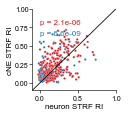

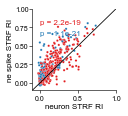

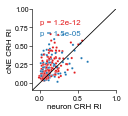

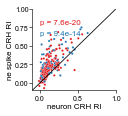

In [81]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 1
data = subsample_summary[(subsample_summary.n_events > 100 )]
for rf in ('strf', 'crh'):
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-.1, 1], [-.1, 1], 'k')
        sns.scatterplot(data=data, x='{}_ri_neuron_mean'.format(rf), y='{}_ri_{}_mean'.format(rf, ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {} RI'.format(rf.upper()))
        plt.ylabel('{} {} RI'.format(ne_param.replace('_', ' '), rf.upper()))
        plt.xlim([-.1, 1])
        plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_ri_neuron_mean'.format(rf)], 
                              y=data[data.region==region]['{}_ri_{}_mean'.format(rf, ne_param)])
            plt.text(0, 0.8-0.15*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_ri_neuron_mean'.format(rf)].mean(), 
                                        data[data.region==region]['{}_ri_{}_mean'.format(rf, ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_ri_neuron_vs_{}_sig.jpg'.format(rf, ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_ri_neuron_vs_{}.jpg'.format(rf, ne_param), bbox_inches='tight', dpi=300)


#### strf PTD, crh moranI

MGB: neuron-10.968518860003467, ne-10.59403189046854
A1: neuron-6.037292231960366, ne-6.222901062006525
MGB: neuron-10.968518860003467, ne-11.609670677920397
A1: neuron-6.037292231960366, ne-6.885229317425066
MGB: neuron-0.17399143928342473, ne-0.23673363768945213
A1: neuron-0.18391097723543473, ne-0.2465057901983696
MGB: neuron-0.17399143928342473, ne-0.2633843468492465
A1: neuron-0.18391097723543473, ne-0.28316778324510866


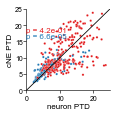

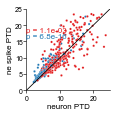

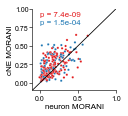

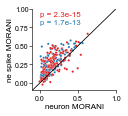

In [88]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 1
data = subsample_summary[(subsample_summary.n_events > 100 )]
param = {'strf': 'ptd', 'crh': 'morani'}
for rf in ['strf', 'crh']:
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-1, 25], [-1, 25], 'k')
        sns.scatterplot(data=data, x='{}_neuron'.format(param[rf]), y='{}_{}'.format(param[rf], ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {}'.format(param[rf].replace('_', ' ').upper()))
        plt.ylabel('{} {}'.format(ne_param.replace('_', ' '), param[rf].replace('_', ' ').upper()))
        if rf == 'strf':
            plt.xlim([0, 25])
            plt.ylim([0, 25])
        else:
            plt.xlim([-.1, 1])
            plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_neuron'.format(param[rf])], 
                              y=data[data.region==region]['{}_{}'.format(param[rf], ne_param)])
            if rf == 'strf':
                plt.text(0, 18-2*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            else:
                plt.text(0, .9-.1*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_neuron'.format(param[rf])].mean(), 
                                        data[data.region==region]['{}_{}'.format(param[rf], ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}_sig.jpg'.format(param[rf], ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}.jpg'.format(param[rf], ne_param), bbox_inches='tight', dpi=300)


#### strf nonlinearity (ASI) and mutual information

MGB: neuron-0.16105877552173078, ne-0.31047645612711544
A1: neuron-0.1149700484963235, ne-0.14346199234279414
MGB: neuron-0.16105877552173078, ne-0.4066546255203205
A1: neuron-0.1149700484963235, ne-0.2414113601508087


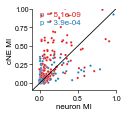

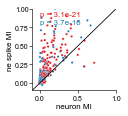

In [89]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 1
data = subsample_summary[(subsample_summary.n_events > 100 )]
for param in ['mi']:
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-1, 25], [-1, 25], 'k')
        sns.scatterplot(data=data, x='{}_neuron'.format(param), y='{}_{}'.format(param, ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {}'.format(param.replace('_', ' ').upper()))
        plt.ylabel('{} {}'.format(ne_param.replace('_', ' '), param.replace('_', ' ').upper()))
        if param == 'asi':
            plt.xlim([.5, 1])
            plt.ylim([.5, 1])
        else:
            plt.xlim([-.1, 1])
            plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_neuron'.format(param)], 
                              y=data[data.region==region]['{}_{}'.format(param, ne_param)])
            if param == 'asi':
                plt.text(.55, .9-.05*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            else:
                plt.text(0, .9-.1*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_neuron'.format(param)].mean(), 
                                        data[data.region==region]['{}_{}'.format(param, ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}_sig.jpg'.format(param, ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}.jpg'.format(param, ne_param), bbox_inches='tight', dpi=300)
